In [ ]:
#ConvLSTM-SED   multivariable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time
# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


# load the dataset
#dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/PD-TVFEMD-IMF1.csv', usecols=[6], engine='python')
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)

timestep = 6
dim = 6
#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:6]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
#X_scaler= scaler.fit_transform(X)
X_scaler = X.reshape(324,-1)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)

#print(X_scaler)
#print(Y_scaler)
#print(Y)


# 将数据拆分成训练和测试，8/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size,:], X_scaler[train_size:len(dataset),:]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX)
#print(trainY)
#print(testX)
#print(testY)



#重构数据集
##timestep为时间步长
def create_trainX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_trainY(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i + timestep])
    return np.array(dataY)

def create_testX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[(i):(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)



#----------forecasting-----------

pres=[]
trainX = create_trainX(trainX, timestep)
trainY = create_trainY(trainY, timestep)
testX = create_testX(testX, timestep) 
testY = testY[timestep:len(testY)]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为5D [samples, timesteps, rows, columns, features]
trainX_input5D = np.reshape(trainX, (trainX.shape[0], 2,1,timestep//2, dim))
testX_input5D = np.reshape(testX, (testX.shape[0],2,1,timestep//2, dim))
#trainX_input5D = np.reshape(trainX, (trainX.shape[0], timestep,1,1, dim))
#testX_input5D = np.reshape(testX, (testX.shape[0],timestep,1,1, dim))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input5D.shape,testX_input5D.shape)


# create and fit the convlstm network
if __name__ == '__main__':
    model = Sequential()
    model.add(ConvLSTM2D(filters=12, kernel_size=(2,2), activation='relu', 
                         input_shape=(2,1,timestep//2, dim),
#                         input_shape=(timestep,1,1, dim),
                         padding='same', return_sequences=True))
    model.add(ConvLSTM2D(filters=12, kernel_size=(2,2), activation='relu',
                         padding='same', return_sequences=True))

    model.add(Flatten())
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input5D, trainY, epochs=1000)

    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input5D)
    testPredict = model.predict(testX_input5D)

    # 逆缩放预测值
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    trainPre = trainPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    trainPre = trainPre.reshape(-1)
    trainPre =pd.DataFrame(trainPre)
    trainPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmtrain.csv', header=False)
    
    testPre = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPre.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX[train_size+timestep:len(dataset)]
    QSX = QSX.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))
    for i in range(len(testY_ori)):
        testPredict[i]=QSX[i] + testPre[i]
    testPredict = testPredict.reshape(-1)

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_ori[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_ori[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPredict[i])
        error1.append(abs((testY_ori[i] - testPredict[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPredict[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPredict[i]*testPredict[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPredict[i+1])/testY_ori[i])*((testY_ori[i+1] - testPredict[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPredict[i])/testY_ori[i])*((testY_ori[i+1] - testPredict[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPredict=testPredict.reshape(-1)
    testPredict=pd.DataFrame(testPredict)
    testPredict.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPredict,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPredict)



end = time.time()
print('Running time: %d seconds'%(end - start))

数据集的长度： 324
原始训练集的长度： 252
原始测试集的长度： 72
转为监督学习，训练集数据长度： 246
转为监督学习，测试集数据长度： 66
构造得到模型的输入数据(训练数据已有标签trainY):  (246, 2, 1, 3, 6) (66, 2, 1, 3, 6)
Train on 246 samples
Epoch 1/1000
246/246 [==============================] - 7s 28ms/sample - loss: 0.2064
Epoch 2/1000
246/246 [==============================] - 0s 361us/sample - loss: 0.1942
Epoch 3/1000
246/246 [==============================] - 0s 312us/sample - loss: 0.1806
Epoch 4/1000
246/246 [==============================] - 0s 320us/sample - loss: 0.1645
Epoch 5/1000
246/246 [==============================] - 0s 308us/sample - loss: 0.1446
Epoch 6/1000
246/246 [==============================] - 0s 458us/sample - loss: 0.1188
Epoch 7/1000
246/246 [==============================] - 0s 397us/sample - loss: 0.0862
Epoch 8/1000
246/246 [==============================] - ETA: 0s - loss: 0.055 - 0s 373us/sample - loss: 0.0519
Epoch 9/1000
246/246 [==============================] - 0s 507us/sample - loss: 0.0358
Epoch 10/1000
246/246 [=======

246/246 [==============================] - 0s 316us/sample - loss: 0.0070
Epoch 93/1000
246/246 [==============================] - 0s 304us/sample - loss: 0.0070
Epoch 94/1000
246/246 [==============================] - 0s 296us/sample - loss: 0.0069
Epoch 95/1000
246/246 [==============================] - 0s 300us/sample - loss: 0.0068
Epoch 96/1000
246/246 [==============================] - 0s 308us/sample - loss: 0.0067
Epoch 97/1000
246/246 [==============================] - 0s 308us/sample - loss: 0.0066
Epoch 98/1000
246/246 [==============================] - 0s 292us/sample - loss: 0.0065
Epoch 99/1000
246/246 [==============================] - 0s 292us/sample - loss: 0.0066
Epoch 100/1000
246/246 [==============================] - 0s 304us/sample - loss: 0.0064
Epoch 101/1000
246/246 [==============================] - 0s 300us/sample - loss: 0.0063
Epoch 102/1000
246/246 [==============================] - 0s 304us/sample - loss: 0.0065
Epoch 103/1000
246/246 [===================

246/246 [==============================] - 0s 316us/sample - loss: 0.0041
Epoch 185/1000
246/246 [==============================] - 0s 292us/sample - loss: 0.0042
Epoch 186/1000
246/246 [==============================] - 0s 300us/sample - loss: 0.0040
Epoch 187/1000
246/246 [==============================] - 0s 296us/sample - loss: 0.0040
Epoch 188/1000
246/246 [==============================] - 0s 300us/sample - loss: 0.0040
Epoch 189/1000
246/246 [==============================] - 0s 296us/sample - loss: 0.0041
Epoch 190/1000
246/246 [==============================] - 0s 312us/sample - loss: 0.0040
Epoch 191/1000
246/246 [==============================] - 0s 284us/sample - loss: 0.0040
Epoch 192/1000
246/246 [==============================] - 0s 304us/sample - loss: 0.0040
Epoch 193/1000
246/246 [==============================] - 0s 292us/sample - loss: 0.0044
Epoch 194/1000
246/246 [==============================] - 0s 296us/sample - loss: 0.0040
Epoch 195/1000
246/246 [============

246/246 [==============================] - 0s 349us/sample - loss: 0.0033
Epoch 277/1000
246/246 [==============================] - 0s 353us/sample - loss: 0.0033
Epoch 278/1000
246/246 [==============================] - 0s 337us/sample - loss: 0.0033
Epoch 279/1000
246/246 [==============================] - 0s 320us/sample - loss: 0.0033
Epoch 280/1000
246/246 [==============================] - 0s 328us/sample - loss: 0.0035
Epoch 281/1000
246/246 [==============================] - 0s 328us/sample - loss: 0.0034
Epoch 282/1000
246/246 [==============================] - 0s 349us/sample - loss: 0.0034
Epoch 283/1000
246/246 [==============================] - 0s 328us/sample - loss: 0.0034
Epoch 284/1000
246/246 [==============================] - 0s 328us/sample - loss: 0.0033
Epoch 285/1000
246/246 [==============================] - 0s 365us/sample - loss: 0.0032
Epoch 286/1000
246/246 [==============================] - 0s 405us/sample - loss: 0.0033
Epoch 287/1000
246/246 [============

246/246 [==============================] - 0s 365us/sample - loss: 0.0029
Epoch 368/1000
246/246 [==============================] - 0s 312us/sample - loss: 0.0030
Epoch 369/1000
246/246 [==============================] - 0s 324us/sample - loss: 0.0030
Epoch 370/1000
246/246 [==============================] - 0s 324us/sample - loss: 0.0029
Epoch 371/1000
246/246 [==============================] - 0s 316us/sample - loss: 0.0030
Epoch 372/1000
246/246 [==============================] - 0s 320us/sample - loss: 0.0030
Epoch 373/1000
246/246 [==============================] - 0s 316us/sample - loss: 0.0029
Epoch 374/1000
246/246 [==============================] - 0s 304us/sample - loss: 0.0029
Epoch 375/1000
246/246 [==============================] - 0s 304us/sample - loss: 0.0029
Epoch 376/1000
246/246 [==============================] - 0s 304us/sample - loss: 0.0030
Epoch 377/1000
246/246 [==============================] - 0s 324us/sample - loss: 0.0029
Epoch 378/1000
246/246 [============

246/246 [==============================] - 0s 357us/sample - loss: 0.0026
Epoch 460/1000
246/246 [==============================] - 0s 357us/sample - loss: 0.0025
Epoch 461/1000
246/246 [==============================] - 0s 430us/sample - loss: 0.0025
Epoch 462/1000
246/246 [==============================] - 0s 385us/sample - loss: 0.0026
Epoch 463/1000
246/246 [==============================] - 0s 450us/sample - loss: 0.0029
Epoch 464/1000
246/246 [==============================] - 0s 349us/sample - loss: 0.0027
Epoch 465/1000
246/246 [==============================] - 0s 324us/sample - loss: 0.0025
Epoch 466/1000
246/246 [==============================] - 0s 345us/sample - loss: 0.0025
Epoch 467/1000
246/246 [==============================] - 0s 332us/sample - loss: 0.0025
Epoch 468/1000
246/246 [==============================] - 0s 357us/sample - loss: 0.0025
Epoch 469/1000
246/246 [==============================] - 0s 337us/sample - loss: 0.0025
Epoch 470/1000
246/246 [============

246/246 [==============================] - 0s 316us/sample - loss: 0.0022
Epoch 552/1000
246/246 [==============================] - 0s 365us/sample - loss: 0.0022
Epoch 553/1000
246/246 [==============================] - 0s 332us/sample - loss: 0.0025
Epoch 554/1000
246/246 [==============================] - 0s 328us/sample - loss: 0.0023
Epoch 555/1000
246/246 [==============================] - 0s 320us/sample - loss: 0.0022
Epoch 556/1000
246/246 [==============================] - 0s 345us/sample - loss: 0.0022
Epoch 557/1000
246/246 [==============================] - 0s 332us/sample - loss: 0.0022
Epoch 558/1000
246/246 [==============================] - 0s 328us/sample - loss: 0.0022
Epoch 559/1000
246/246 [==============================] - 0s 349us/sample - loss: 0.0022
Epoch 560/1000
246/246 [==============================] - 0s 316us/sample - loss: 0.0022
Epoch 561/1000
246/246 [==============================] - 0s 312us/sample - loss: 0.0022
Epoch 562/1000
246/246 [============

246/246 [==============================] - 0s 316us/sample - loss: 0.0021
Epoch 644/1000
246/246 [==============================] - 0s 345us/sample - loss: 0.0020
Epoch 645/1000
246/246 [==============================] - 0s 316us/sample - loss: 0.0021
Epoch 646/1000
246/246 [==============================] - 0s 328us/sample - loss: 0.0020
Epoch 647/1000
246/246 [==============================] - 0s 341us/sample - loss: 0.0020
Epoch 648/1000
246/246 [==============================] - 0s 324us/sample - loss: 0.0020
Epoch 649/1000
246/246 [==============================] - 0s 324us/sample - loss: 0.0019
Epoch 650/1000
246/246 [==============================] - 0s 328us/sample - loss: 0.0019
Epoch 651/1000
246/246 [==============================] - 0s 332us/sample - loss: 0.0020
Epoch 652/1000
246/246 [==============================] - 0s 345us/sample - loss: 0.0019
Epoch 653/1000
246/246 [==============================] - 0s 357us/sample - loss: 0.0019
Epoch 654/1000
246/246 [============

数据集的长度： 324
原始训练集的长度： 252
原始测试集的长度： 72
转为监督学习，训练集数据长度： 246
转为监督学习，测试集数据长度： 66
构造得到模型的输入数据(训练数据已有标签trainY):  (246, 6, 2, 3, 1) (66, 6, 2, 3, 1)
Train on 246 samples
Epoch 1/1000
246/246 [==============================] - 4s 18ms/sample - loss: 0.0505
Epoch 2/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0476
Epoch 3/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0439
Epoch 4/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0405
Epoch 5/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0377
Epoch 6/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0356
Epoch 7/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0338
Epoch 8/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0325
Epoch 9/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0313
Epoch 10/1000
246/246 [==============================] - 0s 1ms/sample

246/246 [==============================] - 0s 1ms/sample - loss: 0.0030
Epoch 189/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0027
Epoch 190/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0023
Epoch 191/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0022
Epoch 192/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0023
Epoch 193/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0021
Epoch 194/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0021
Epoch 195/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0023
Epoch 196/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0022
Epoch 197/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0023
Epoch 198/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0027
Epoch 199/1000
246/246 [==============================] - 

246/246 [==============================] - 0s 1ms/sample - loss: 0.0018
Epoch 283/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0018
Epoch 284/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0018
Epoch 285/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0018
Epoch 286/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0018
Epoch 287/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0017
Epoch 288/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0017
Epoch 289/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0020
Epoch 290/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0021
Epoch 291/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0019
Epoch 292/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0020
Epoch 293/1000
246/246 [==============================] - 

246/246 [==============================] - 0s 2ms/sample - loss: 0.0012
Epoch 471/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0011
Epoch 472/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0012
Epoch 473/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0011
Epoch 474/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0011
Epoch 475/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0012
Epoch 476/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0012
Epoch 477/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0012
Epoch 478/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0012
Epoch 479/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0012
Epoch 480/1000
246/246 [==============================] - 0s 1ms/sample - loss: 0.0011
Epoch 481/1000
246/246 [==============================] - 

246/246 [==============================] - 0s 2ms/sample - loss: 9.9592e-04
Epoch 564/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0011
Epoch 565/1000
246/246 [==============================] - 0s 2ms/sample - loss: 9.5432e-04
Epoch 566/1000
246/246 [==============================] - 0s 2ms/sample - loss: 9.7971e-04 0s - loss: 0.001
Epoch 567/1000
246/246 [==============================] - 0s 1ms/sample - loss: 9.6834e-04
Epoch 568/1000
246/246 [==============================] - 0s 2ms/sample - loss: 9.7749e-04
Epoch 569/1000
246/246 [==============================] - 0s 2ms/sample - loss: 9.7213e-04
Epoch 570/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0011
Epoch 571/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0011
Epoch 572/1000
246/246 [==============================] - 0s 1ms/sample - loss: 9.6063e-04
Epoch 573/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0011
Epoch 574/100

246/246 [==============================] - 0s 1ms/sample - loss: 7.2890e-04
Epoch 744/1000
246/246 [==============================] - 0s 1ms/sample - loss: 7.8139e-04
Epoch 745/1000
246/246 [==============================] - 0s 1ms/sample - loss: 7.5119e-04
Epoch 746/1000
246/246 [==============================] - 0s 1ms/sample - loss: 7.4734e-04
Epoch 747/1000
246/246 [==============================] - 0s 1ms/sample - loss: 7.6293e-04
Epoch 748/1000
246/246 [==============================] - 0s 1ms/sample - loss: 7.4137e-04
Epoch 749/1000
246/246 [==============================] - 0s 1ms/sample - loss: 7.2410e-04
Epoch 750/1000
246/246 [==============================] - 0s 1ms/sample - loss: 7.7810e-04
Epoch 751/1000
246/246 [==============================] - 0s 1ms/sample - loss: 9.0556e-04
Epoch 752/1000
246/246 [==============================] - 0s 1ms/sample - loss: 8.5080e-04
Epoch 753/1000
246/246 [==============================] - 0s 1ms/sample - loss: 7.5230e-04
Epoch 754/1000

246/246 [==============================] - 0s 1ms/sample - loss: 6.4808e-04
Epoch 924/1000
246/246 [==============================] - 0s 1ms/sample - loss: 6.7357e-04
Epoch 925/1000
246/246 [==============================] - 0s 1ms/sample - loss: 5.7591e-04
Epoch 926/1000
246/246 [==============================] - 0s 1ms/sample - loss: 5.5588e-04
Epoch 927/1000
246/246 [==============================] - 0s 1ms/sample - loss: 5.7726e-04
Epoch 928/1000
246/246 [==============================] - 0s 1ms/sample - loss: 5.8442e-04
Epoch 929/1000
246/246 [==============================] - 0s 1ms/sample - loss: 6.3142e-04
Epoch 930/1000
246/246 [==============================] - 0s 1ms/sample - loss: 5.8152e-04
Epoch 931/1000
246/246 [==============================] - 0s 1ms/sample - loss: 5.5493e-04
Epoch 932/1000
246/246 [==============================] - 0s 1ms/sample - loss: 5.6092e-04
Epoch 933/1000
246/246 [==============================] - 0s 1ms/sample - loss: 5.4475e-04
Epoch 934/1000

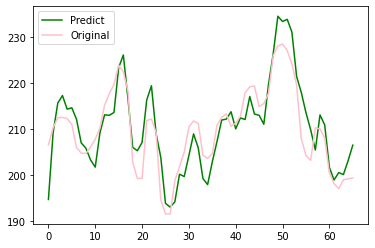

Running time: 366 seconds


In [10]:
#TSRconvlstm 2,3,1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time
# fix random seed for reproducibility
np.random.seed(7)

start = time.time()

# load the dataset
#dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/PD-IMF1.csv', usecols=[6], engine='python')
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)
X11 = dataset[:,0]#Y
X11_scaler= (X11-np.min(X11))/(np.max(X11)-np.min(X11))
X11_scaler = X11_scaler.reshape(-1)

X12 = dataset[:,1]
X12_scaler= (X12-np.min(X12))/(np.max(X12)-np.min(X12))
X12_scaler = X12_scaler.reshape(-1)

X13 = dataset[:,2]
X13_scaler= (X13-np.min(X13))/(np.max(X13)-np.min(X13))
X13_scaler = X13_scaler.reshape(-1)

X21 = dataset[:,3]
X21_scaler= (X21-np.min(X21))/(np.max(X21)-np.min(X21))
X21_scaler = X21_scaler.reshape(-1)

X22 = dataset[:,4]
X22_scaler= (X22-np.min(X22))/(np.max(X22)-np.min(X22))
X22_scaler = X22_scaler.reshape(-1)

X23 = dataset[:,5]
X23_scaler= (X23-np.min(X23))/(np.max(X23)-np.min(X23))
X23_scaler = X23_scaler.reshape(-1)



XX = np.zeros([324,2,3])
XX[:,0,0] = X11_scaler
XX[:,0,1] = X12_scaler
XX[:,0,2] = X13_scaler
XX[:,1,0] = X21_scaler
XX[:,1,1] = X22_scaler
XX[:,1,2] = X23_scaler

# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
train, test = XX[0:train_size,:,:], XX[train_size:len(dataset),:,:]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)


# 切片
def create_train(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
        # Y向后移动一位取值
        dataY.append(seq[i + timestep,:,:])
    return np.array(dataX), np.array(dataY)

def create_testX(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
    return np.array(dataX)



#----------forecasting-----------
timestep = 6
pres=[]
trainX,trainY = create_train(train, timestep)
testX = create_testX(test, timestep) 
testY = test[timestep:len(X11),0,0]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为5D [samples, timesteps, rows, columns, features]
trainX_input5D = np.reshape(trainX, (trainX.shape[0], timestep,2,3, 1))
testX_input5D = np.reshape(testX, (testX.shape[0],timestep, 2,3, 1))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input5D.shape,testX_input5D.shape)


# create and fit the convlstm network
from tensorflow.python.keras.layers.convolutional import Conv3D ,Conv2D
if __name__ == '__main__':
    model = Sequential()
    model.add(ConvLSTM2D(filters=72, kernel_size=(2, 2), activation='relu', input_shape=(timestep, 2,3,1),
                         padding='same',return_sequences=True))
    model.add(ConvLSTM2D(filters=12, kernel_size=(1, 2),activation='relu',
                         padding='same',return_sequences=False))
    model.add(Conv2D(filters=1, kernel_size=(1, 1),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
#    model.add(Flatten())
#    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input5D, trainY, epochs=1000)

    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input5D)
    testPredict = model.predict(testX_input5D)
    
    # 逆缩放预测值
    trainPre1 = trainPredict[:,0,0,:]
    trainPre1 = trainPre1.reshape(-1)
    
    testPre1 = testPredict[:,0,0,:]
    testPre1 = testPre1.reshape(-1)
    
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]#Y
    
    trainPre = trainPre1*((np.max(Y)-np.min(Y)))+np.min(Y)
    trainPre = trainPre.reshape(-1)
    trainPre =pd.DataFrame(trainPre)
    trainPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmtrain.csv', header=False)
    
    testBDX_re = testPre1*((np.max(Y)-np.min(Y)))+np.min(Y)
    testBDX_re = testBDX_re.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX[train_size+timestep:len(dataset)]
    QSX = QSX.reshape(-1)
    testPre_re=QSX + testBDX_re
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_re[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_re[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre_re[i])
        error1.append(abs((testY_ori[i] - testPre_re[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre_re[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre_re[i]*testPre_re[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre_re[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre_re[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre_re[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre_re[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre_re[i])/testY_ori[i])*((testY_ori[i+1] - testPre_re[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre_re=testPre_re.reshape(-1)
    testPre_re=pd.DataFrame(testPre_re)
    testPre_re.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre_re,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre_re)



end = time.time()
print('Running time: %d seconds'%(end - start))

数据集的长度： 324
原始训练集的长度： 252
原始测试集的长度： 72
转为监督学习，训练集数据长度： 246
转为监督学习，测试集数据长度： 66
构造得到模型的输入数据(训练数据已有标签trainY):  (246, 6, 3, 3, 1) (66, 6, 3, 3, 1)
Train on 246 samples
Epoch 1/1000
246/246 [==============================] - 6s 26ms/sample - loss: 0.0490
Epoch 2/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0473
Epoch 3/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0443
Epoch 4/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0410
Epoch 5/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0388
Epoch 6/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0378
Epoch 7/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0373
Epoch 8/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0363
Epoch 9/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0358
Epoch 10/1000
246/246 [==============================] - 1s 2ms/sample

246/246 [==============================] - 1s 2ms/sample - loss: 0.0040
Epoch 189/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0040
Epoch 190/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0036
Epoch 191/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0036
Epoch 192/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0037
Epoch 193/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0039
Epoch 194/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0039
Epoch 195/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0035
Epoch 196/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0037
Epoch 197/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0039
Epoch 198/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0038
Epoch 199/1000
246/246 [==============================] - 

246/246 [==============================] - 1s 2ms/sample - loss: 0.0024
Epoch 375/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0025
Epoch 376/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0025
Epoch 377/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0026
Epoch 378/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0025
Epoch 379/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0028
Epoch 380/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0026
Epoch 381/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0025
Epoch 382/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0023
Epoch 383/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0024
Epoch 384/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0024
Epoch 385/1000
246/246 [==============================] - 

246/246 [==============================] - 0s 2ms/sample - loss: 0.0018
Epoch 469/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0018
Epoch 470/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0018
Epoch 471/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0018
Epoch 472/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0020
Epoch 473/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0019
Epoch 474/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0019
Epoch 475/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0019
Epoch 476/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0019
Epoch 477/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0018
Epoch 478/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0018
Epoch 479/1000
246/246 [==============================] - 

246/246 [==============================] - 1s 2ms/sample - loss: 0.0013
Epoch 656/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0014
Epoch 657/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0014
Epoch 658/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0014
Epoch 659/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0015
Epoch 660/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0014
Epoch 661/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0018
Epoch 662/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0018
Epoch 663/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0015
Epoch 664/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0014
Epoch 665/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0014
Epoch 666/1000
246/246 [==============================] - 

246/246 [==============================] - 1s 2ms/sample - loss: 0.0012
Epoch 750/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0012
Epoch 751/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0011
Epoch 752/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0011
Epoch 753/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0011
Epoch 754/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0011
Epoch 755/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0011
Epoch 756/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0013
Epoch 757/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0012
Epoch 758/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0011
Epoch 759/1000
246/246 [==============================] - 1s 2ms/sample - loss: 0.0011
Epoch 760/1000
246/246 [==============================] - 

246/246 [==============================] - 1s 2ms/sample - loss: 8.9371e-04
Epoch 936/1000
246/246 [==============================] - 0s 2ms/sample - loss: 9.0910e-04
Epoch 937/1000
246/246 [==============================] - 1s 2ms/sample - loss: 9.7061e-04
Epoch 938/1000
246/246 [==============================] - 1s 2ms/sample - loss: 9.4933e-04
Epoch 939/1000
246/246 [==============================] - 1s 2ms/sample - loss: 9.0473e-04
Epoch 940/1000
246/246 [==============================] - 1s 2ms/sample - loss: 9.0563e-04
Epoch 941/1000
246/246 [==============================] - 1s 2ms/sample - loss: 9.8701e-04
Epoch 942/1000
246/246 [==============================] - 1s 2ms/sample - loss: 9.0437e-04
Epoch 943/1000
246/246 [==============================] - 1s 2ms/sample - loss: 8.9125e-04
Epoch 944/1000
246/246 [==============================] - 1s 2ms/sample - loss: 9.2861e-04
Epoch 945/1000
246/246 [==============================] - 1s 2ms/sample - loss: 9.0649e-04
Epoch 946/1000

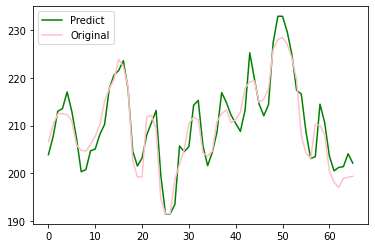

Running time: 523 seconds


In [11]:
#TSRconvlstm3,3,1
import numpy
import pandas
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.python.keras.layers import ConvLSTM2D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time
# fix random seed for reproducibility
numpy.random.seed(7)

start = time.time()

# load the dataset
#dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/PD-IMF1.csv', usecols=[6], engine='python')
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)
X1 = dataset[:,1]#Y
X1_scaler= (X1-numpy.min(X1))/(numpy.max(X1)-numpy.min(X1))
X1_scaler = X1_scaler.reshape(-1)

X2 = dataset[:,2]
X2_scaler= (X2-numpy.min(X2))/(numpy.max(X2)-numpy.min(X2))
X2_scaler = X2_scaler.reshape(-1)

X3 = dataset[:,3]
X3_scaler= (X3-numpy.min(X3))/(numpy.max(X3)-numpy.min(X3))
X3_scaler = X3_scaler.reshape(-1)

X4 = dataset[:,4]
X4_scaler= (X4-numpy.min(X4))/(numpy.max(X4)-numpy.min(X4))
X4_scaler = X4_scaler.reshape(-1)

X5 = dataset[:,5]
X5_scaler= (X5-numpy.min(X5))/(numpy.max(X5)-numpy.min(X5))
X5_scaler = X5_scaler.reshape(-1)

Y = dataset[:,0]
Y_scaler= (Y-numpy.min(Y))/(numpy.max(Y)-numpy.min(Y))
Y_scaler = Y_scaler.reshape(-1)



XX = numpy.zeros([324,3,3])
XX[:,0,0] = X1_scaler
XX[:,0,1] = Y_scaler
XX[:,0,2] = X2_scaler
XX[:,1,0] = Y_scaler
XX[:,1,1] = X3_scaler
XX[:,1,2] = Y_scaler
XX[:,2,0] = X4_scaler
XX[:,2,1] = Y_scaler
XX[:,2,2] = X5_scaler

# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
train, test = XX[0:train_size,:,:], XX[train_size:len(dataset),:,:]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)


# 切片
def create_train(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
        # Y向后移动一位取值
        dataY.append(seq[i + timestep,:,:])
    return numpy.array(dataX), numpy.array(dataY)

def create_testX(seq, timestep):
    dataX, dataY = [], []
    for i in range(len(seq)-timestep):
        a = seq[i:(i + timestep),:,:]
        # X按照顺序取值
        dataX.append(a)
    return numpy.array(dataX)
# fix random seed for reproducibility
numpy.random.seed(7)



#----------forecasting-----------
timestep = 6
pres=[]
trainX,trainY = create_train(train, timestep)
testX = create_testX(test, timestep) 
testY = test[timestep:len(X11),0,0]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为5D [samples, timesteps, rows, columns, features]
trainX_input5D = numpy.reshape(trainX, (trainX.shape[0], timestep,3,3, 1))
testX_input5D = numpy.reshape(testX, (testX.shape[0],timestep, 3,3, 1))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input5D.shape,testX_input5D.shape)


# create and fit the convlstm network
from tensorflow.python.keras.layers.convolutional import Conv3D ,Conv2D
if __name__ == '__main__':
    model = Sequential()
    model.add(ConvLSTM2D(filters=48, kernel_size=(2, 2), activation='relu', input_shape=(timestep, 3,3,1),
                         padding='same',return_sequences=True))
    model.add(ConvLSTM2D(filters=24, kernel_size=(2, 2),activation='relu',
                         padding='same',return_sequences=True))
    model.add(ConvLSTM2D(filters=12, kernel_size=(1, 1),activation='relu',
                         padding='same',return_sequences=False))
    model.add(Conv2D(filters=1, kernel_size=(1, 1),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
#    model.add(Flatten())
#    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input5D, trainY, epochs=1000)

    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input5D)
    testPredict = model.predict(testX_input5D)
    
    
    # 逆缩放预测值
    trainPre1 = trainPredict[:,1,0,:]
    trainPre1 = trainPre1.reshape(-1)
    
    testPre1 = testPredict[:,1,0,:]
    testPre1 = testPre1.reshape(-1)
    
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]#Y
    
    trainPre = trainPre1*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    trainPre = trainPre.reshape(-1)
    trainPre =pandas.DataFrame(trainPre)
    trainPre.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmtrain.csv', header=False)
    
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]#Y
    testBDX_re = testPre1*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    testBDX_re = testBDX_re.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX[train_size+timestep:len(dataset)]
    QSX = QSX.reshape(-1)
    testPre_re=QSX + testBDX_re
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))

    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_re[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_re[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPre_re[i])
        error1.append(abs((testY_ori[i] - testPre_re[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPre_re[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPre_re[i]*testPre_re[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=numpy.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPre_re[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPre_re[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPre_re[i+1])/testY_ori[i])*((testY_ori[i+1] - testPre_re[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPre_re[i])/testY_ori[i])*((testY_ori[i+1] - testPre_re[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPre_re=testPre_re.reshape(-1)
    testPre_re=pandas.DataFrame(testPre_re)
    testPre_re.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/convlstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)
    
    plt.figure(facecolor='white')
    plt.plot(testPre_re,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPre_re)



end = time.time()
print('Running time: %d seconds'%(end - start))

数据集的长度： 324
原始训练集的长度： 252
原始测试集的长度： 72
转为监督学习，训练集数据长度： 246
转为监督学习，测试集数据长度： 66
构造得到模型的输入数据(训练数据已有标签trainY):  (246, 1, 6, 6) (66, 1, 6, 6)
Train on 246 samples
Epoch 1/1000
246/246 [==============================] - 0s 2ms/sample - loss: 0.0842
Epoch 2/1000
246/246 [==============================] - 0s 69us/sample - loss: 0.0449
Epoch 3/1000
246/246 [==============================] - 0s 65us/sample - loss: 0.0350
Epoch 4/1000
246/246 [==============================] - 0s 110us/sample - loss: 0.0290
Epoch 5/1000
246/246 [==============================] - 0s 77us/sample - loss: 0.0255
Epoch 6/1000
246/246 [==============================] - 0s 69us/sample - loss: 0.0219
Epoch 7/1000
246/246 [==============================] - 0s 89us/sample - loss: 0.0189
Epoch 8/1000
246/246 [==============================] - 0s 77us/sample - loss: 0.0164
Epoch 9/1000
246/246 [==============================] - 0s 85us/sample - loss: 0.0142
Epoch 10/1000
246/246 [==============================] - 0s 77us/sam

246/246 [==============================] - 0s 69us/sample - loss: 0.0018
Epoch 185/1000
246/246 [==============================] - 0s 77us/sample - loss: 0.0018
Epoch 186/1000
246/246 [==============================] - 0s 81us/sample - loss: 0.0018
Epoch 187/1000
246/246 [==============================] - 0s 81us/sample - loss: 0.0017
Epoch 188/1000
246/246 [==============================] - 0s 77us/sample - loss: 0.0019
Epoch 189/1000
246/246 [==============================] - 0s 81us/sample - loss: 0.0019
Epoch 190/1000
246/246 [==============================] - 0s 77us/sample - loss: 0.0020
Epoch 191/1000
246/246 [==============================] - 0s 77us/sample - loss: 0.0020
Epoch 192/1000
246/246 [==============================] - 0s 69us/sample - loss: 0.0017
Epoch 193/1000
246/246 [==============================] - 0s 73us/sample - loss: 0.0019
Epoch 194/1000
246/246 [==============================] - 0s 69us/sample - loss: 0.0018
Epoch 195/1000
246/246 [=======================

Epoch 370/1000
246/246 [==============================] - 0s 65us/sample - loss: 0.0011
Epoch 371/1000
246/246 [==============================] - 0s 81us/sample - loss: 0.0012
Epoch 372/1000
246/246 [==============================] - 0s 77us/sample - loss: 0.0011
Epoch 373/1000
246/246 [==============================] - 0s 73us/sample - loss: 0.0011
Epoch 374/1000
246/246 [==============================] - 0s 69us/sample - loss: 0.0011
Epoch 375/1000
246/246 [==============================] - 0s 73us/sample - loss: 0.0012
Epoch 376/1000
246/246 [==============================] - 0s 89us/sample - loss: 0.0012
Epoch 377/1000
246/246 [==============================] - 0s 77us/sample - loss: 0.0010
Epoch 378/1000
246/246 [==============================] - 0s 81us/sample - loss: 0.0012
Epoch 379/1000
246/246 [==============================] - 0s 77us/sample - loss: 0.0013
Epoch 380/1000
246/246 [==============================] - 0s 81us/sample - loss: 0.0013
Epoch 381/1000
246/246 [========

246/246 [==============================] - 0s 77us/sample - loss: 7.3855e-04
Epoch 551/1000
246/246 [==============================] - 0s 77us/sample - loss: 8.6985e-04
Epoch 552/1000
246/246 [==============================] - 0s 81us/sample - loss: 8.0429e-04
Epoch 553/1000
246/246 [==============================] - 0s 69us/sample - loss: 8.8061e-04
Epoch 554/1000
246/246 [==============================] - 0s 81us/sample - loss: 7.8521e-04
Epoch 555/1000
246/246 [==============================] - 0s 69us/sample - loss: 7.4729e-04
Epoch 556/1000
246/246 [==============================] - 0s 77us/sample - loss: 7.2062e-04
Epoch 557/1000
246/246 [==============================] - 0s 77us/sample - loss: 9.3954e-04
Epoch 558/1000
246/246 [==============================] - 0s 77us/sample - loss: 0.0011
Epoch 559/1000
246/246 [==============================] - 0s 73us/sample - loss: 8.1069e-04
Epoch 560/1000
246/246 [==============================] - 0s 77us/sample - loss: 7.1843e-04
Epoch 5

246/246 [==============================] - 0s 81us/sample - loss: 5.1339e-04
Epoch 728/1000
246/246 [==============================] - 0s 81us/sample - loss: 5.1681e-04
Epoch 729/1000
246/246 [==============================] - 0s 81us/sample - loss: 5.5649e-04
Epoch 730/1000
246/246 [==============================] - 0s 73us/sample - loss: 5.2476e-04
Epoch 731/1000
246/246 [==============================] - 0s 77us/sample - loss: 6.4002e-04
Epoch 732/1000
246/246 [==============================] - 0s 85us/sample - loss: 6.3994e-04
Epoch 733/1000
246/246 [==============================] - 0s 69us/sample - loss: 5.0404e-04
Epoch 734/1000
246/246 [==============================] - 0s 69us/sample - loss: 4.9507e-04
Epoch 735/1000
246/246 [==============================] - 0s 85us/sample - loss: 5.1380e-04
Epoch 736/1000
246/246 [==============================] - 0s 101us/sample - loss: 5.0653e-04
Epoch 737/1000
246/246 [==============================] - 0s 73us/sample - loss: 4.9194e-04
Ep

246/246 [==============================] - 0s 81us/sample - loss: 4.4245e-04
Epoch 817/1000
246/246 [==============================] - 0s 77us/sample - loss: 4.7183e-04
Epoch 818/1000
246/246 [==============================] - 0s 81us/sample - loss: 4.5319e-04
Epoch 819/1000
246/246 [==============================] - 0s 73us/sample - loss: 4.3006e-04
Epoch 820/1000
246/246 [==============================] - 0s 97us/sample - loss: 4.4294e-04
Epoch 821/1000
246/246 [==============================] - 0s 93us/sample - loss: 4.6951e-04
Epoch 822/1000
246/246 [==============================] - 0s 97us/sample - loss: 4.3527e-04
Epoch 823/1000
246/246 [==============================] - 0s 81us/sample - loss: 4.1810e-04
Epoch 824/1000
246/246 [==============================] - 0s 77us/sample - loss: 4.4021e-04
Epoch 825/1000
246/246 [==============================] - 0s 77us/sample - loss: 4.6183e-04
Epoch 826/1000
246/246 [==============================] - 0s 85us/sample - loss: 5.5832e-04
Epo

246/246 [==============================] - 0s 77us/sample - loss: 3.4060e-04
Epoch 995/1000
246/246 [==============================] - ETA: 0s - loss: 2.0748e-0 - 0s 81us/sample - loss: 3.0798e-04
Epoch 996/1000
246/246 [==============================] - 0s 77us/sample - loss: 2.9582e-04
Epoch 997/1000
246/246 [==============================] - 0s 81us/sample - loss: 3.2519e-04
Epoch 998/1000
246/246 [==============================] - 0s 77us/sample - loss: 3.5876e-04
Epoch 999/1000
246/246 [==============================] - 0s 77us/sample - loss: 3.4424e-04
Epoch 1000/1000
246/246 [==============================] - 0s 77us/sample - loss: 3.0330e-04
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist multiple                  780       
_________________________________________________________________
time_distributed_10 (TimeDis multiple                  

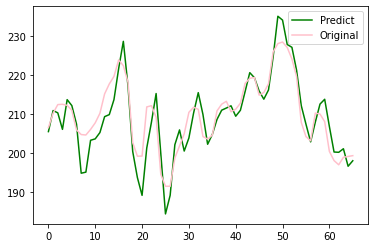

Running time: 21 seconds


In [14]:
#CNN-SED
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.convolutional import MaxPooling1D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time

# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


# load the dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)

timestep = 6
dim = 6
#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:6]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)


# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size,:], X_scaler[train_size:len(dataset),:]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX)
#print(trainY)
#print(testX)
#print(testY)



#重构数据集
##timestep为时间步长
def create_trainX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_trainY(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i + timestep])
    return np.array(dataY)

def create_testX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[(i):(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)



#----------forecasting-----------
pres=[]
trainX = create_trainX(trainX, timestep)
trainY = create_trainY(trainY, timestep)
testX = create_testX(testX, timestep) 
testY = testY[timestep:len(testY)]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为4D [samples, subsequences, timesteps, features]
trainX_input4D = np.reshape(trainX, (trainX.shape[0],1,timestep,dim))
testX_input4D = np.reshape(testX, (testX.shape[0],1,timestep,dim))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input4D.shape,testX_input4D.shape)


# create and fit the convlstm network
if __name__ == '__main__':
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=60, kernel_size=2, activation='relu', input_shape=(None,1, testX.shape[1]))))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))

    #model.add(LSTM(4,activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input4D, trainY, epochs=1000)
    


    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input4D)
    testPredict = model.predict(testX_input4D)

    # 逆缩放预测值
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPredict = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX[train_size+timestep:len(dataset)]
    QSX = QSX.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))
    for i in range(len(testY_ori)):
        testPredict[i]=QSX[i] + testPre[i]
    testPredict = testPredict.reshape(-1)
        
    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_re[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_re[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPredict[i])
        error1.append(abs((testY_ori[i] - testPredict[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPredict[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPredict[i]*testPredict[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPredict[i+1])/testY_ori[i])*((testY_ori[i+1] - testPredict[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPredict[i])/testY_ori[i])*((testY_ori[i+1] - testPredict[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPredict=testPredict.reshape(-1)
    testPredict=pd.DataFrame(testPredict)
    testPredict.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/cnnoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/cnnEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)

    plt.figure(facecolor='white')
    plt.plot(testPredict,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPredict)



end = time.time()
print('Running time: %d seconds'%(end - start))

数据集的长度： 324
原始训练集的长度： 252
原始测试集的长度： 72
转为监督学习，训练集数据长度： 246
转为监督学习，测试集数据长度： 66
构造得到模型的输入数据(训练数据已有标签trainY):  (246, 1, 6, 6) (66, 1, 6, 6)
Train on 246 samples
Epoch 1/1000
246/246 [==============================] - 2s 9ms/sample - loss: 0.1963
Epoch 2/1000
246/246 [==============================] - 0s 138us/sample - loss: 0.1578
Epoch 3/1000
246/246 [==============================] - 0s 109us/sample - loss: 0.0803
Epoch 4/1000
246/246 [==============================] - 0s 162us/sample - loss: 0.0430
Epoch 5/1000
246/246 [==============================] - 0s 146us/sample - loss: 0.0396
Epoch 6/1000
246/246 [==============================] - 0s 170us/sample - loss: 0.0373
Epoch 7/1000
246/246 [==============================] - 0s 150us/sample - loss: 0.0328
Epoch 8/1000
246/246 [==============================] - 0s 122us/sample - loss: 0.0300
Epoch 9/1000
246/246 [==============================] - 0s 134us/sample - loss: 0.0273
Epoch 10/1000
246/246 [==============================] - 0s 1

246/246 [==============================] - 0s 114us/sample - loss: 0.0024
Epoch 185/1000
246/246 [==============================] - 0s 126us/sample - loss: 0.0022
Epoch 186/1000
246/246 [==============================] - 0s 142us/sample - loss: 0.0022
Epoch 187/1000
246/246 [==============================] - 0s 138us/sample - loss: 0.0021
Epoch 188/1000
246/246 [==============================] - 0s 130us/sample - loss: 0.0020
Epoch 189/1000
246/246 [==============================] - 0s 146us/sample - loss: 0.0021
Epoch 190/1000
246/246 [==============================] - 0s 162us/sample - loss: 0.0021
Epoch 191/1000
246/246 [==============================] - 0s 150us/sample - loss: 0.0022
Epoch 192/1000
246/246 [==============================] - 0s 154us/sample - loss: 0.0021
Epoch 193/1000
246/246 [==============================] - 0s 142us/sample - loss: 0.0021
Epoch 194/1000
246/246 [==============================] - 0s 146us/sample - loss: 0.0022
Epoch 195/1000
246/246 [============

Epoch 276/1000
246/246 [==============================] - 0s 122us/sample - loss: 0.0018
Epoch 277/1000
246/246 [==============================] - 0s 142us/sample - loss: 0.0019
Epoch 278/1000
246/246 [==============================] - 0s 122us/sample - loss: 0.0020
Epoch 279/1000
246/246 [==============================] - 0s 142us/sample - loss: 0.0020
Epoch 280/1000
246/246 [==============================] - 0s 118us/sample - loss: 0.0022
Epoch 281/1000
246/246 [==============================] - 0s 146us/sample - loss: 0.0022
Epoch 282/1000
246/246 [==============================] - 0s 146us/sample - loss: 0.0019
Epoch 283/1000
246/246 [==============================] - 0s 130us/sample - loss: 0.0021
Epoch 284/1000
246/246 [==============================] - 0s 126us/sample - loss: 0.0023
Epoch 285/1000
246/246 [==============================] - 0s 142us/sample - loss: 0.0020
Epoch 286/1000
246/246 [==============================] - 0s 146us/sample - loss: 0.0018
Epoch 287/1000
246/24

246/246 [==============================] - 0s 138us/sample - loss: 0.0015
Epoch 460/1000
246/246 [==============================] - 0s 134us/sample - loss: 0.0015
Epoch 461/1000
246/246 [==============================] - 0s 158us/sample - loss: 0.0015
Epoch 462/1000
246/246 [==============================] - 0s 130us/sample - loss: 0.0017
Epoch 463/1000
246/246 [==============================] - 0s 138us/sample - loss: 0.0016
Epoch 464/1000
246/246 [==============================] - 0s 130us/sample - loss: 0.0015
Epoch 465/1000
246/246 [==============================] - 0s 126us/sample - loss: 0.0016
Epoch 466/1000
246/246 [==============================] - 0s 138us/sample - loss: 0.0021
Epoch 467/1000
246/246 [==============================] - 0s 118us/sample - loss: 0.0017
Epoch 468/1000
246/246 [==============================] - 0s 142us/sample - loss: 0.0018
Epoch 469/1000
246/246 [==============================] - 0s 126us/sample - loss: 0.0020
Epoch 470/1000
246/246 [============

246/246 [==============================] - 0s 126us/sample - loss: 0.0011
Epoch 644/1000
246/246 [==============================] - 0s 154us/sample - loss: 0.0011
Epoch 645/1000
246/246 [==============================] - 0s 122us/sample - loss: 0.0011
Epoch 646/1000
246/246 [==============================] - 0s 142us/sample - loss: 0.0013
Epoch 647/1000
246/246 [==============================] - 0s 130us/sample - loss: 0.0011
Epoch 648/1000
246/246 [==============================] - 0s 133us/sample - loss: 0.0011
Epoch 649/1000
246/246 [==============================] - 0s 126us/sample - loss: 0.0015
Epoch 650/1000
246/246 [==============================] - 0s 138us/sample - loss: 0.0015
Epoch 651/1000
246/246 [==============================] - 0s 126us/sample - loss: 0.0016
Epoch 652/1000
246/246 [==============================] - 0s 134us/sample - loss: 0.0015
Epoch 653/1000
246/246 [==============================] - 0s 126us/sample - loss: 0.0011
Epoch 654/1000
246/246 [============

246/246 [==============================] - 0s 130us/sample - loss: 8.5104e-04
Epoch 823/1000
246/246 [==============================] - 0s 134us/sample - loss: 8.0481e-04
Epoch 824/1000
246/246 [==============================] - 0s 134us/sample - loss: 7.7397e-04
Epoch 825/1000
246/246 [==============================] - 0s 146us/sample - loss: 7.9435e-04
Epoch 826/1000
246/246 [==============================] - 0s 134us/sample - loss: 8.3971e-04
Epoch 827/1000
246/246 [==============================] - 0s 126us/sample - loss: 8.8326e-04
Epoch 828/1000
246/246 [==============================] - 0s 130us/sample - loss: 7.7403e-04
Epoch 829/1000
246/246 [==============================] - 0s 126us/sample - loss: 7.7692e-04
Epoch 830/1000
246/246 [==============================] - 0s 138us/sample - loss: 7.8441e-04
Epoch 831/1000
246/246 [==============================] - 0s 126us/sample - loss: 7.8187e-04
Epoch 832/1000
246/246 [==============================] - 0s 146us/sample - loss: 8.3

246/246 [==============================] - 0s 134us/sample - loss: 6.0777e-04
Epoch 998/1000
246/246 [==============================] - 0s 134us/sample - loss: 6.3316e-04
Epoch 999/1000
246/246 [==============================] - 0s 146us/sample - loss: 6.5314e-04
Epoch 1000/1000
246/246 [==============================] - 0s 142us/sample - loss: 6.4479e-04
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist multiple                  336       
_________________________________________________________________
time_distributed_4 (TimeDist multiple                  0         
_________________________________________________________________
time_distributed_5 (TimeDist multiple                  0         
_________________________________________________________________
lstm (LSTM)                  multiple                  64704     
_________________________

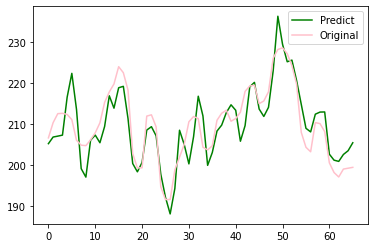

Running time: 37 seconds


In [13]:
#CNN-LSTM-SED
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.convolutional import MaxPooling1D
from tensorflow.python.keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline
import time

# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


# load the dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
#print(dataframe)
print("数据集的长度：",len(dataframe))
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')
#print(dataset)

timestep = 6
dim = 6
#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:6]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)


# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size,:], X_scaler[train_size:len(dataset),:]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX)
#print(trainY)
#print(testX)
#print(testY)



#重构数据集
##timestep为时间步长
def create_trainX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_trainY(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i + timestep])
    return np.array(dataY)

def create_testX(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[(i):(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)



#----------forecasting-----------
pres=[]
trainX = create_trainX(trainX, timestep)
trainY = create_trainY(trainY, timestep)
testX = create_testX(testX, timestep) 
testY = testY[timestep:len(testY)]
print("转为监督学习，训练集数据长度：", len(trainX))
#print(trainX,trainY)
print("转为监督学习，测试集数据长度：",len(testX))
#print(testX, testY )


# 数据重构为4D [samples, subsequences, timesteps, features]
trainX_input4D = np.reshape(trainX, (trainX.shape[0],1,timestep,dim))
testX_input4D = np.reshape(testX, (testX.shape[0],1,timestep,dim))
print('构造得到模型的输入数据(训练数据已有标签trainY): ',trainX_input4D.shape,testX_input4D.shape)


# create and fit the convlstm network
if __name__ == '__main__':
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=48, kernel_size=1, activation='relu', input_shape=(None,1, testX.shape[1]))))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(48,activation='relu',return_sequences=True))
    model.add(LSTM(12,activation='relu',return_sequences=True))
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam')
    model.fit(trainX_input4D, trainY, epochs=1000)
    


    # 打印模型
    model.summary()

    # 开始预测
    trainPredict = model.predict(trainX_input4D)
    testPredict = model.predict(testX_input4D)

    # 逆缩放预测值
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    #trainPredict = trainPredict*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori = trainY*((numpy.max(Y)-numpy.min(Y)))+numpy.min(Y)
    #trainY_ori=trainY_re.reshape((246,1))
    testPredict = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPredict.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX[train_size+timestep:len(dataset)]
    QSX = QSX.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))
    for i in range(len(testY_ori)):
        testPredict[i]=QSX[i] + testPre[i]
    testPredict = testPredict.reshape(-1)
        
        
    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_re[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_re[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPredict[i])
        error1.append(abs((testY_ori[i] - testPredict[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPredict[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPredict[i]*testPredict[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPredict[i+1])/testY_ori[i])*((testY_ori[i+1] - testPredict[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPredict[i])/testY_ori[i])*((testY_ori[i+1] - testPredict[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPredict=testPredict.reshape(-1)
    testPredict=pd.DataFrame(testPredict)
    testPredict.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/cnnoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/cnnEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)

    plt.figure(facecolor='white')
    plt.plot(testPredict,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPredict)



end = time.time()
print('Running time: %d seconds'%(end - start))

(324, 6)
(324,)
原始训练集的长度： 252
原始测试集的长度： 72
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 6)]            0         
_________________________________________________________________
gru (GRU)                    (None, 6, 60)             12060     
_________________________________________________________________
gru_1 (GRU)                  (None, 6, 12)             2628      
_________________________________________________________________
flatten (Flatten)            (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73        
Total params: 14,761
Trainable params: 14,761
Non-trainable params: 0
_________________________________________________________________
None
Train on 246 samples
Epoch 1/1000
246/246 [==============================] 

Epoch 82/1000
246/246 [==============================] - 0s 138us/sample - loss: 0.0017
Epoch 83/1000
246/246 [==============================] - 0s 178us/sample - loss: 0.0017
Epoch 84/1000
246/246 [==============================] - 0s 166us/sample - loss: 0.0017
Epoch 85/1000
246/246 [==============================] - 0s 162us/sample - loss: 0.0017
Epoch 86/1000
246/246 [==============================] - 0s 162us/sample - loss: 0.0015
Epoch 87/1000
246/246 [==============================] - 0s 158us/sample - loss: 0.0015
Epoch 88/1000
246/246 [==============================] - 0s 150us/sample - loss: 0.0017
Epoch 89/1000
246/246 [==============================] - 0s 170us/sample - loss: 0.0016
Epoch 90/1000
246/246 [==============================] - 0s 158us/sample - loss: 0.0015
Epoch 91/1000
246/246 [==============================] - 0s 174us/sample - loss: 0.0015
Epoch 92/1000
246/246 [==============================] - 0s 146us/sample - loss: 0.0014
Epoch 93/1000
246/246 [=========

246/246 [==============================] - 0s 158us/sample - loss: 1.7930e-04
Epoch 260/1000
246/246 [==============================] - 0s 166us/sample - loss: 2.0621e-04
Epoch 261/1000
246/246 [==============================] - 0s 150us/sample - loss: 1.9016e-04
Epoch 262/1000
246/246 [==============================] - 0s 174us/sample - loss: 2.2739e-04
Epoch 263/1000
246/246 [==============================] - 0s 158us/sample - loss: 3.0486e-04
Epoch 264/1000
246/246 [==============================] - 0s 150us/sample - loss: 3.1447e-04
Epoch 265/1000
246/246 [==============================] - 0s 158us/sample - loss: 1.7225e-04
Epoch 266/1000
246/246 [==============================] - 0s 158us/sample - loss: 2.0913e-04
Epoch 267/1000
246/246 [==============================] - 0s 154us/sample - loss: 2.4523e-04
Epoch 268/1000
246/246 [==============================] - 0s 170us/sample - loss: 3.6693e-04
Epoch 269/1000
246/246 [==============================] - 0s 186us/sample - loss: 4.0

246/246 [==============================] - 0s 142us/sample - loss: 3.4126e-05
Epoch 436/1000
246/246 [==============================] - 0s 146us/sample - loss: 3.1391e-05
Epoch 437/1000
246/246 [==============================] - 0s 162us/sample - loss: 3.2919e-05
Epoch 438/1000
246/246 [==============================] - 0s 162us/sample - loss: 3.3348e-05
Epoch 439/1000
246/246 [==============================] - 0s 158us/sample - loss: 3.3840e-05
Epoch 440/1000
246/246 [==============================] - 0s 174us/sample - loss: 2.9164e-05
Epoch 441/1000
246/246 [==============================] - 0s 166us/sample - loss: 2.7959e-05
Epoch 442/1000
246/246 [==============================] - 0s 166us/sample - loss: 2.6392e-05
Epoch 443/1000
246/246 [==============================] - 0s 162us/sample - loss: 2.8698e-05
Epoch 444/1000
246/246 [==============================] - 0s 166us/sample - loss: 3.1038e-05
Epoch 445/1000
246/246 [==============================] - 0s 158us/sample - loss: 3.0

246/246 [==============================] - 0s 174us/sample - loss: 1.0554e-05
Epoch 612/1000
246/246 [==============================] - 0s 174us/sample - loss: 1.0199e-05
Epoch 613/1000
246/246 [==============================] - 0s 158us/sample - loss: 9.5348e-06
Epoch 614/1000
246/246 [==============================] - 0s 166us/sample - loss: 9.6349e-06
Epoch 615/1000
246/246 [==============================] - 0s 142us/sample - loss: 8.7089e-06
Epoch 616/1000
246/246 [==============================] - 0s 162us/sample - loss: 8.6670e-06
Epoch 617/1000
246/246 [==============================] - 0s 170us/sample - loss: 8.2824e-06
Epoch 618/1000
246/246 [==============================] - 0s 170us/sample - loss: 8.5344e-06
Epoch 619/1000
246/246 [==============================] - 0s 162us/sample - loss: 8.0312e-06
Epoch 620/1000
246/246 [==============================] - 0s 154us/sample - loss: 8.6709e-06
Epoch 621/1000
246/246 [==============================] - 0s 158us/sample - loss: 8.7

246/246 [==============================] - 0s 186us/sample - loss: 3.6690e-05
Epoch 788/1000
246/246 [==============================] - 0s 174us/sample - loss: 4.7562e-05
Epoch 789/1000
246/246 [==============================] - 0s 154us/sample - loss: 1.0215e-04
Epoch 790/1000
246/246 [==============================] - 0s 174us/sample - loss: 1.4153e-04
Epoch 791/1000
246/246 [==============================] - 0s 170us/sample - loss: 1.9021e-04
Epoch 792/1000
246/246 [==============================] - 0s 178us/sample - loss: 1.5827e-04
Epoch 793/1000
246/246 [==============================] - 0s 154us/sample - loss: 1.9847e-04
Epoch 794/1000
246/246 [==============================] - 0s 186us/sample - loss: 1.7189e-04
Epoch 795/1000
246/246 [==============================] - 0s 162us/sample - loss: 1.8808e-04
Epoch 796/1000
246/246 [==============================] - 0s 215us/sample - loss: 1.9404e-04
Epoch 797/1000
246/246 [==============================] - 0s 191us/sample - loss: 1.4

Epoch 963/1000
246/246 [==============================] - 0s 166us/sample - loss: 1.5792e-04
Epoch 964/1000
246/246 [==============================] - 0s 162us/sample - loss: 1.0963e-04
Epoch 965/1000
246/246 [==============================] - 0s 170us/sample - loss: 8.9354e-05
Epoch 966/1000
246/246 [==============================] - 0s 207us/sample - loss: 8.6147e-05
Epoch 967/1000
246/246 [==============================] - 0s 191us/sample - loss: 1.1263e-04
Epoch 968/1000
246/246 [==============================] - 0s 166us/sample - loss: 8.4989e-05
Epoch 969/1000
246/246 [==============================] - 0s 186us/sample - loss: 7.1828e-05
Epoch 970/1000
246/246 [==============================] - 0s 162us/sample - loss: 1.1309e-04
Epoch 971/1000
246/246 [==============================] - 0s 150us/sample - loss: 1.0100e-04
Epoch 972/1000
246/246 [==============================] - 0s 154us/sample - loss: 8.6306e-05
Epoch 973/1000
246/246 [==============================] - 0s 178us/sam

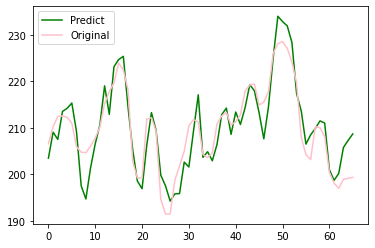

Running time: 47 seconds


In [15]:
#GRU_SED
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
import time

start = time.time()

np.random.seed(6)
#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 6

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:6]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)
print(X_scaler.shape)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)

#-------------------------------------------#
#  建立注意力模型
#-------------------------------------------#
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
#    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
#        if print_shape_only:
#            print(layer_activations.shape)
#        else:
#            print(layer_activations)
    return activations

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)#(batch_size, time_steps, input_dim)
    output_attention_mul = Multiply()([inputs, a_probs])#(batch_size, time_steps, input_dim)
    return output_attention_mul


def get_gru_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    gru_units1 = 60
    gru_units2 = 12
    # (batch_size, time_steps, INPUT_DIM) -> (batch_size, input_dim, lstm_units)
    gur_out1 = GRU(gru_units1,return_sequences=True)(inputs)
    gur_out2 = GRU(gru_units2,return_sequences=True)(gur_out1)
    # (batch_size, input_dim, lstm_units) -> (batch_size, input_dim*lstm_units)
    gur_out = Flatten()(gur_out2)
    output = Dense(1, activation='sigmoid')(gur_out)
    model = Model(inputs=inputs, outputs=output)
    return model



#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size,:], X_scaler[train_size:len(dataset),:]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
    np.random.seed(6)
        
    model = get_gru_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=1000, batch_size=64)

    # 开始预测
    trainPredict = model.predict(train_X)
    testPredict = model.predict(test_X)
    
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    testPre = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPre.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX[train_size+timestep:len(dataset)]
    QSX = QSX.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))
    for i in range(len(testY_ori)):
        testPredict[i]=QSX[i] + testPre[i]
    testPredict = testPredict.reshape(-1)
        
        
    # 计算误差
    #trainScore = math.sqrt(mean_squared_error(trainY_re[:,0], trainPredict[:,0]))
    #print('Train Score: %.2f RMSE' % (trainScore))
    #testScore = math.sqrt(mean_squared_error(testY_re[:,0], testPredict[:,0]))
    #print('Test Score: %.2f RMSE' % (testScore))


    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPredict[i])
        error1.append(abs((testY_ori[i] - testPredict[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPredict[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPredict[i]*testPredict[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPredict[i+1])/testY_ori[i])*((testY_ori[i+1] - testPredict[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPredict[i])/testY_ori[i])*((testY_ori[i+1] - testPredict[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPredict=testPredict.reshape(-1)
    testPredict=pd.DataFrame(testPredict)
    testPredict.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/gruoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/gruEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)

    plt.figure(facecolor='white')
    plt.plot(testPredict,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPredict)



end = time.time()
print('Running time: %d seconds'%(end - start))

(324, 6)
(324,)
原始训练集的长度： 252
原始测试集的长度： 72
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 6)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 60)             16080     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 12)             3504      
_________________________________________________________________
flatten (Flatten)            (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73        
Total params: 19,657
Trainable params: 19,657
Non-trainable params: 0
_________________________________________________________________
None
Train on 246 samples
Epoch 1/1000
246/246 [==============================] 

Epoch 82/1000
246/246 [==============================] - 0s 211us/sample - loss: 0.0020
Epoch 83/1000
246/246 [==============================] - 0s 199us/sample - loss: 0.0021
Epoch 84/1000
246/246 [==============================] - 0s 203us/sample - loss: 0.0025
Epoch 85/1000
246/246 [==============================] - 0s 182us/sample - loss: 0.0023
Epoch 86/1000
246/246 [==============================] - 0s 178us/sample - loss: 0.0023
Epoch 87/1000
246/246 [==============================] - 0s 174us/sample - loss: 0.0022
Epoch 88/1000
246/246 [==============================] - 0s 195us/sample - loss: 0.0021
Epoch 89/1000
246/246 [==============================] - 0s 195us/sample - loss: 0.0025
Epoch 90/1000
246/246 [==============================] - 0s 195us/sample - loss: 0.0026
Epoch 91/1000
246/246 [==============================] - 0s 186us/sample - loss: 0.0032
Epoch 92/1000
246/246 [==============================] - 0s 186us/sample - loss: 0.0021
Epoch 93/1000
246/246 [=========

Epoch 174/1000
246/246 [==============================] - 0s 186us/sample - loss: 0.0011
Epoch 175/1000
246/246 [==============================] - 0s 154us/sample - loss: 0.0012
Epoch 176/1000
246/246 [==============================] - 0s 195us/sample - loss: 0.0012
Epoch 177/1000
246/246 [==============================] - 0s 211us/sample - loss: 0.0012
Epoch 178/1000
246/246 [==============================] - 0s 182us/sample - loss: 0.0012
Epoch 179/1000
246/246 [==============================] - 0s 174us/sample - loss: 0.0011
Epoch 180/1000
246/246 [==============================] - 0s 195us/sample - loss: 0.0010
Epoch 181/1000
246/246 [==============================] - 0s 182us/sample - loss: 9.8568e-04
Epoch 182/1000
246/246 [==============================] - 0s 170us/sample - loss: 9.9304e-04
Epoch 183/1000
246/246 [==============================] - 0s 191us/sample - loss: 0.0010
Epoch 184/1000
246/246 [==============================] - 0s 195us/sample - loss: 0.0010
Epoch 185/100

246/246 [==============================] - 0s 150us/sample - loss: 3.4219e-04
Epoch 264/1000
246/246 [==============================] - 0s 170us/sample - loss: 3.7963e-04
Epoch 265/1000
246/246 [==============================] - 0s 207us/sample - loss: 3.9487e-04
Epoch 266/1000
246/246 [==============================] - 0s 219us/sample - loss: 4.2695e-04
Epoch 267/1000
246/246 [==============================] - 0s 166us/sample - loss: 4.2123e-04
Epoch 268/1000
246/246 [==============================] - 0s 158us/sample - loss: 4.2471e-04
Epoch 269/1000
246/246 [==============================] - 0s 178us/sample - loss: 3.7968e-04
Epoch 270/1000
246/246 [==============================] - 0s 186us/sample - loss: 3.6863e-04
Epoch 271/1000
246/246 [==============================] - 0s 170us/sample - loss: 3.6958e-04
Epoch 272/1000
246/246 [==============================] - 0s 182us/sample - loss: 3.8975e-04
Epoch 273/1000
246/246 [==============================] - 0s 166us/sample - loss: 3.6

246/246 [==============================] - 0s 162us/sample - loss: 1.2977e-04
Epoch 439/1000
246/246 [==============================] - 0s 150us/sample - loss: 1.7485e-04
Epoch 440/1000
246/246 [==============================] - 0s 186us/sample - loss: 1.4464e-04
Epoch 441/1000
246/246 [==============================] - 0s 207us/sample - loss: 1.5507e-04
Epoch 442/1000
246/246 [==============================] - 0s 166us/sample - loss: 1.6186e-04
Epoch 443/1000
246/246 [==============================] - 0s 191us/sample - loss: 1.5162e-04
Epoch 444/1000
246/246 [==============================] - 0s 170us/sample - loss: 1.0105e-04
Epoch 445/1000
246/246 [==============================] - 0s 182us/sample - loss: 1.2827e-04
Epoch 446/1000
246/246 [==============================] - 0s 178us/sample - loss: 1.1203e-04
Epoch 447/1000
246/246 [==============================] - 0s 186us/sample - loss: 1.2458e-04
Epoch 448/1000
246/246 [==============================] - 0s 186us/sample - loss: 1.2

246/246 [==============================] - 0s 195us/sample - loss: 4.5342e-05
Epoch 615/1000
246/246 [==============================] - 0s 195us/sample - loss: 4.6219e-05
Epoch 616/1000
246/246 [==============================] - 0s 203us/sample - loss: 3.3699e-05
Epoch 617/1000
246/246 [==============================] - 0s 158us/sample - loss: 2.8836e-05
Epoch 618/1000
246/246 [==============================] - 0s 186us/sample - loss: 2.5518e-05
Epoch 619/1000
246/246 [==============================] - 0s 182us/sample - loss: 2.7532e-05
Epoch 620/1000
246/246 [==============================] - 0s 174us/sample - loss: 2.7062e-05
Epoch 621/1000
246/246 [==============================] - 0s 186us/sample - loss: 2.9249e-05
Epoch 622/1000
246/246 [==============================] - 0s 191us/sample - loss: 2.5663e-05
Epoch 623/1000
246/246 [==============================] - 0s 186us/sample - loss: 3.3631e-05
Epoch 624/1000
246/246 [==============================] - 0s 146us/sample - loss: 3.3

246/246 [==============================] - 0s 195us/sample - loss: 2.4112e-05
Epoch 791/1000
246/246 [==============================] - 0s 207us/sample - loss: 3.7401e-05
Epoch 792/1000
246/246 [==============================] - 0s 203us/sample - loss: 3.3160e-05
Epoch 793/1000
246/246 [==============================] - 0s 215us/sample - loss: 2.4940e-05
Epoch 794/1000
246/246 [==============================] - 0s 178us/sample - loss: 1.9623e-05
Epoch 795/1000
246/246 [==============================] - 0s 203us/sample - loss: 1.7278e-05
Epoch 796/1000
246/246 [==============================] - 0s 186us/sample - loss: 1.5370e-05
Epoch 797/1000
246/246 [==============================] - 0s 191us/sample - loss: 1.5826e-05
Epoch 798/1000
246/246 [==============================] - 0s 182us/sample - loss: 1.1105e-05
Epoch 799/1000
246/246 [==============================] - 0s 199us/sample - loss: 1.6641e-05
Epoch 800/1000
246/246 [==============================] - 0s 182us/sample - loss: 1.4

Epoch 878/1000
246/246 [==============================] - 0s 195us/sample - loss: 9.1398e-06
Epoch 879/1000
246/246 [==============================] - 0s 174us/sample - loss: 1.0138e-05
Epoch 880/1000
246/246 [==============================] - 0s 203us/sample - loss: 1.1682e-05
Epoch 881/1000
246/246 [==============================] - 0s 178us/sample - loss: 1.1286e-05
Epoch 882/1000
246/246 [==============================] - 0s 178us/sample - loss: 9.2463e-06
Epoch 883/1000
246/246 [==============================] - 0s 170us/sample - loss: 1.0555e-05
Epoch 884/1000
246/246 [==============================] - 0s 199us/sample - loss: 1.3815e-05
Epoch 885/1000
246/246 [==============================] - 0s 199us/sample - loss: 1.3744e-05
Epoch 886/1000
246/246 [==============================] - 0s 186us/sample - loss: 1.5235e-05
Epoch 887/1000
246/246 [==============================] - 0s 170us/sample - loss: 2.0054e-05
Epoch 888/1000
246/246 [==============================] - 0s 191us/sam

246/246 [==============================] - 0s 211us/sample - loss: 2.1711e-05
Epoch 967/1000
246/246 [==============================] - 0s 227us/sample - loss: 3.6518e-05
Epoch 968/1000
246/246 [==============================] - 0s 207us/sample - loss: 3.8096e-05
Epoch 969/1000
246/246 [==============================] - 0s 231us/sample - loss: 3.4284e-05
Epoch 970/1000
246/246 [==============================] - 0s 215us/sample - loss: 2.7717e-05
Epoch 971/1000
246/246 [==============================] - 0s 219us/sample - loss: 5.1509e-05
Epoch 972/1000
246/246 [==============================] - 0s 191us/sample - loss: 6.3691e-05
Epoch 973/1000
246/246 [==============================] - 0s 251us/sample - loss: 9.2910e-05
Epoch 974/1000
246/246 [==============================] - 0s 280us/sample - loss: 1.3044e-04
Epoch 975/1000
246/246 [==============================] - 0s 243us/sample - loss: 1.6458e-04
Epoch 976/1000
246/246 [==============================] - 0s 178us/sample - loss: 1.6

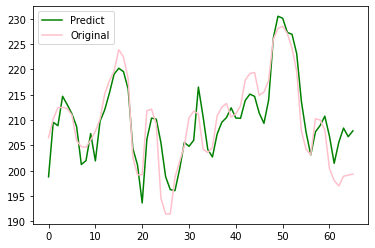

Running time: 52 seconds


In [17]:
#LSTM-SED
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
np.random.seed(6)
import time
start = time.time()

#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 6

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:6]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)
print(X_scaler.shape)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)



def get_lstm_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    lstm_units1 = 60
    lstm_units2 = 12
    lstm_out1 = LSTM(lstm_units1, return_sequences=True)(inputs)
    lstm_out2 = LSTM(lstm_units2, return_sequences=True)(lstm_out1)
    lstm_out = Flatten()(lstm_out2)
    output = Dense(1, activation='relu')(lstm_out)
    model = Model(inputs=inputs, outputs=output)
    return model



#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size], X_scaler[train_size:len(dataset)]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
    np.random.seed(6)
        
    model = get_lstm_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=1000, batch_size=64)

    # 开始预测
    trainPredict = model.predict(train_X)
    testPredict = model.predict(test_X)
    
    
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    testPre = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPre.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX[train_size+timestep:len(dataset)]
    QSX = QSX.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))
    for i in range(len(testY_ori)):
        testPredict[i]=QSX[i] + testPre[i]
    testPredict = testPredict.reshape(-1)
        

    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPredict[i])
        error1.append(abs((testY_ori[i] - testPredict[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPredict[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPredict[i]*testPredict[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPredict[i+1])/testY_ori[i])*((testY_ori[i+1] - testPredict[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPredict[i])/testY_ori[i])*((testY_ori[i+1] - testPredict[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPredict=testPredict.reshape(-1)
    testPredict=pd.DataFrame(testPredict)
    testPredict.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)

    plt.figure(facecolor='white')
    plt.plot(testPredict,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPredict)
    
end = time.time()
print('Running time: %d seconds'%(end - start))

(324, 6)
(324,)
原始训练集的长度： 252
原始测试集的长度： 72
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 6)]            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 6, 120)            32160     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 12)             6384      
_________________________________________________________________
dropout (Dropout)            (None, 6, 12)             0         
_________________________________________________________________
flatten (Flatten)            (None, 72)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 73        
Total params: 38,617
Trainable params: 38,617
Non-trainable params: 0
______________

246/246 [==============================] - 0s 272us/sample - loss: 0.0033
Epoch 173/1000
246/246 [==============================] - 0s 280us/sample - loss: 0.0032
Epoch 174/1000
246/246 [==============================] - 0s 264us/sample - loss: 0.0032
Epoch 175/1000
246/246 [==============================] - 0s 243us/sample - loss: 0.0029
Epoch 176/1000
246/246 [==============================] - 0s 255us/sample - loss: 0.0030
Epoch 177/1000
246/246 [==============================] - 0s 255us/sample - loss: 0.0029
Epoch 178/1000
246/246 [==============================] - 0s 231us/sample - loss: 0.0029
Epoch 179/1000
246/246 [==============================] - 0s 247us/sample - loss: 0.0027
Epoch 180/1000
246/246 [==============================] - 0s 247us/sample - loss: 0.0028
Epoch 181/1000
246/246 [==============================] - 0s 259us/sample - loss: 0.0025
Epoch 182/1000
246/246 [==============================] - 0s 259us/sample - loss: 0.0027
Epoch 183/1000
246/246 [============

246/246 [==============================] - 0s 300us/sample - loss: 0.0013
Epoch 357/1000
246/246 [==============================] - 0s 304us/sample - loss: 0.0016
Epoch 358/1000
246/246 [==============================] - 0s 280us/sample - loss: 0.0016
Epoch 359/1000
246/246 [==============================] - 0s 276us/sample - loss: 0.0015
Epoch 360/1000
246/246 [==============================] - 0s 272us/sample - loss: 0.0016
Epoch 361/1000
246/246 [==============================] - 0s 308us/sample - loss: 0.0016
Epoch 362/1000
246/246 [==============================] - 0s 264us/sample - loss: 0.0016
Epoch 363/1000
246/246 [==============================] - 0s 284us/sample - loss: 0.0016
Epoch 364/1000
246/246 [==============================] - 0s 268us/sample - loss: 0.0017
Epoch 365/1000
246/246 [==============================] - 0s 349us/sample - loss: 0.0016
Epoch 366/1000
246/246 [==============================] - 0s 320us/sample - loss: 0.0014
Epoch 367/1000
246/246 [============

246/246 [==============================] - 0s 272us/sample - loss: 0.0013
Epoch 541/1000
246/246 [==============================] - 0s 300us/sample - loss: 0.0012
Epoch 542/1000
246/246 [==============================] - 0s 272us/sample - loss: 0.0011
Epoch 543/1000
246/246 [==============================] - 0s 272us/sample - loss: 0.0014
Epoch 544/1000
246/246 [==============================] - 0s 255us/sample - loss: 0.0014
Epoch 545/1000
246/246 [==============================] - 0s 235us/sample - loss: 0.0013
Epoch 546/1000
246/246 [==============================] - 0s 280us/sample - loss: 0.0012
Epoch 547/1000
246/246 [==============================] - 0s 247us/sample - loss: 0.0013
Epoch 548/1000
246/246 [==============================] - 0s 272us/sample - loss: 0.0013
Epoch 549/1000
246/246 [==============================] - 0s 251us/sample - loss: 0.0012
Epoch 550/1000
246/246 [==============================] - 0s 235us/sample - loss: 0.0013
Epoch 551/1000
246/246 [============

Epoch 632/1000
246/246 [==============================] - 0s 276us/sample - loss: 0.0010
Epoch 633/1000
246/246 [==============================] - 0s 264us/sample - loss: 0.0012
Epoch 634/1000
246/246 [==============================] - 0s 276us/sample - loss: 9.8946e-04
Epoch 635/1000
246/246 [==============================] - 0s 243us/sample - loss: 0.0010
Epoch 636/1000
246/246 [==============================] - 0s 280us/sample - loss: 9.8515e-04
Epoch 637/1000
246/246 [==============================] - 0s 268us/sample - loss: 0.0011
Epoch 638/1000
246/246 [==============================] - 0s 276us/sample - loss: 0.0011
Epoch 639/1000
246/246 [==============================] - 0s 284us/sample - loss: 0.0011
Epoch 640/1000
246/246 [==============================] - 0s 284us/sample - loss: 9.0042e-04
Epoch 641/1000
246/246 [==============================] - 0s 264us/sample - loss: 8.9536e-04
Epoch 642/1000
246/246 [==============================] - 0s 247us/sample - loss: 0.0011
Epoch

Epoch 723/1000
246/246 [==============================] - 0s 268us/sample - loss: 0.0011
Epoch 724/1000
246/246 [==============================] - 0s 292us/sample - loss: 9.0131e-04
Epoch 725/1000
246/246 [==============================] - 0s 276us/sample - loss: 9.5018e-04
Epoch 726/1000
246/246 [==============================] - 0s 280us/sample - loss: 0.0011
Epoch 727/1000
246/246 [==============================] - 0s 268us/sample - loss: 9.9196e-04
Epoch 728/1000
246/246 [==============================] - 0s 247us/sample - loss: 0.0010
Epoch 729/1000
246/246 [==============================] - 0s 268us/sample - loss: 9.9672e-04
Epoch 730/1000
246/246 [==============================] - 0s 284us/sample - loss: 0.0011
Epoch 731/1000
246/246 [==============================] - 0s 264us/sample - loss: 0.0011
Epoch 732/1000
246/246 [==============================] - 0s 243us/sample - loss: 0.0013
Epoch 733/1000
246/246 [==============================] - 0s 284us/sample - loss: 0.0012
Epoch

246/246 [==============================] - 0s 284us/sample - loss: 9.0224e-04
Epoch 905/1000
246/246 [==============================] - 0s 292us/sample - loss: 8.3013e-04
Epoch 906/1000
246/246 [==============================] - 0s 268us/sample - loss: 0.0013
Epoch 907/1000
246/246 [==============================] - 0s 280us/sample - loss: 0.0011
Epoch 908/1000
246/246 [==============================] - 0s 276us/sample - loss: 9.1083e-04
Epoch 909/1000
246/246 [==============================] - 0s 272us/sample - loss: 9.3272e-04
Epoch 910/1000
246/246 [==============================] - 0s 276us/sample - loss: 0.0010
Epoch 911/1000
246/246 [==============================] - 0s 296us/sample - loss: 0.0012
Epoch 912/1000
246/246 [==============================] - 0s 259us/sample - loss: 0.0011
Epoch 913/1000
246/246 [==============================] - 0s 251us/sample - loss: 0.0010
Epoch 914/1000
246/246 [==============================] - 0s 268us/sample - loss: 8.8971e-04
Epoch 915/1000
2

Epoch 994/1000
246/246 [==============================] - 0s 268us/sample - loss: 7.5842e-04
Epoch 995/1000
246/246 [==============================] - 0s 296us/sample - loss: 9.4963e-04
Epoch 996/1000
246/246 [==============================] - 0s 268us/sample - loss: 8.6985e-04
Epoch 997/1000
246/246 [==============================] - 0s 239us/sample - loss: 7.0012e-04
Epoch 998/1000
246/246 [==============================] - 0s 280us/sample - loss: 7.8497e-04
Epoch 999/1000
246/246 [==============================] - 0s 276us/sample - loss: 9.3685e-04
Epoch 1000/1000
246/246 [==============================] - 0s 264us/sample - loss: 9.1665e-04

MAE= [3.3749924]
RMSE =  4.355175333446243
NMSE =  [0.02900085]
MAPE= [0.0162757]
IA= [0.93406117]
U1= 0.010335877006069971
U2= 0.6416380365859435


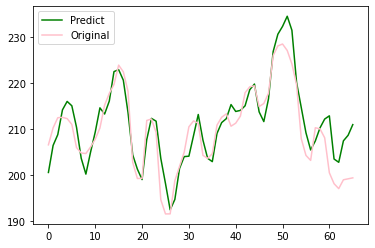

Running time: 77 seconds


In [18]:
#Bi-LSTM-SED
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
import time
# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 6

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:6]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)
print(X_scaler.shape)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)



def get_bilstm_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    lstm_units1 = 60
    lstm_units2 = 12
    bilstm_out1 = Bidirectional(LSTM(lstm_units1,return_sequences=True),merge_mode='concat')(inputs)
    bilstm_out2 = LSTM(lstm_units2, return_sequences=True)(bilstm_out1)
    dropout_out = Dropout(0.5)(bilstm_out2)
    bilstm_out = Flatten()(dropout_out)
    output = Dense(1, activation='relu')(bilstm_out)
    model = Model(inputs=inputs, outputs=output)
    return model



#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size], X_scaler[train_size:len(dataset)]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':
        
    model = get_bilstm_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=1000, batch_size=64)

    # 开始预测
    trainPredict = model.predict(train_X)
    testPredict = model.predict(test_X)
    
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    testPre = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPre.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX[train_size+timestep:len(dataset)]
    QSX = QSX.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))
    for i in range(len(testY_ori)):
        testPredict[i]=QSX[i] + testPre[i]
    testPredict = testPredict.reshape(-1)

    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPredict[i])
        error1.append(abs((testY_ori[i] - testPredict[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPredict[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPredict[i]*testPredict[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPredict[i+1])/testY_ori[i])*((testY_ori[i+1] - testPredict[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPredict[i])/testY_ori[i])*((testY_ori[i+1] - testPredict[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPredict=testPredict.reshape(-1)
    testPredict=pd.DataFrame(testPredict)
    testPredict.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/lstmEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)

    plt.figure(facecolor='white')
    plt.plot(testPredict,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPredict)
    
end = time.time()
print('Running time: %d seconds'%(end - start))

(324, 6)
(324,)
原始训练集的长度： 252
原始测试集的长度： 72
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 6)]       0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 6, 6)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 6, 6)         42          permute[0][0]                    
__________________________________________________________________________________________________
attention_vec (Permute)         (None, 6, 6)         0           dense[0][0]                      
___________________________________________________

246/246 [==============================] - 0s 158us/sample - loss: 0.0022
Epoch 159/1000
246/246 [==============================] - 0s 146us/sample - loss: 0.0021
Epoch 160/1000
246/246 [==============================] - 0s 182us/sample - loss: 0.0020
Epoch 161/1000
246/246 [==============================] - 0s 166us/sample - loss: 0.0020
Epoch 162/1000
246/246 [==============================] - 0s 166us/sample - loss: 0.0021
Epoch 163/1000
246/246 [==============================] - 0s 186us/sample - loss: 0.0020
Epoch 164/1000
246/246 [==============================] - 0s 158us/sample - loss: 0.0020
Epoch 165/1000
246/246 [==============================] - 0s 154us/sample - loss: 0.0020
Epoch 166/1000
246/246 [==============================] - 0s 154us/sample - loss: 0.0023
Epoch 167/1000
246/246 [==============================] - 0s 150us/sample - loss: 0.0022
Epoch 168/1000
246/246 [==============================] - 0s 166us/sample - loss: 0.0021
Epoch 169/1000
246/246 [============

246/246 [==============================] - 0s 162us/sample - loss: 9.8919e-04
Epoch 251/1000
246/246 [==============================] - 0s 162us/sample - loss: 0.0010
Epoch 252/1000
246/246 [==============================] - 0s 182us/sample - loss: 0.0011
Epoch 253/1000
246/246 [==============================] - 0s 178us/sample - loss: 0.0012
Epoch 254/1000
246/246 [==============================] - 0s 150us/sample - loss: 0.0012
Epoch 255/1000
246/246 [==============================] - 0s 142us/sample - loss: 0.0014
Epoch 256/1000
246/246 [==============================] - 0s 154us/sample - loss: 0.0013
Epoch 257/1000
246/246 [==============================] - 0s 170us/sample - loss: 9.9475e-04
Epoch 258/1000
246/246 [==============================] - 0s 150us/sample - loss: 0.0011
Epoch 259/1000
246/246 [==============================] - 0s 178us/sample - loss: 0.0010
Epoch 260/1000
246/246 [==============================] - 0s 158us/sample - loss: 0.0013
Epoch 261/1000
246/246 [====

246/246 [==============================] - 0s 199us/sample - loss: 3.0043e-04
Epoch 427/1000
246/246 [==============================] - 0s 199us/sample - loss: 3.0157e-04
Epoch 428/1000
246/246 [==============================] - 0s 207us/sample - loss: 3.6758e-04
Epoch 429/1000
246/246 [==============================] - 0s 182us/sample - loss: 3.8645e-04
Epoch 430/1000
246/246 [==============================] - 0s 195us/sample - loss: 3.9789e-04
Epoch 431/1000
246/246 [==============================] - 0s 186us/sample - loss: 4.6734e-04
Epoch 432/1000
246/246 [==============================] - 0s 215us/sample - loss: 4.1336e-04
Epoch 433/1000
246/246 [==============================] - 0s 203us/sample - loss: 4.2548e-04
Epoch 434/1000
246/246 [==============================] - 0s 203us/sample - loss: 4.0619e-04
Epoch 435/1000
246/246 [==============================] - 0s 182us/sample - loss: 3.4569e-04
Epoch 436/1000
246/246 [==============================] - 0s 199us/sample - loss: 3.6

246/246 [==============================] - 0s 158us/sample - loss: 1.0622e-04
Epoch 603/1000
246/246 [==============================] - 0s 174us/sample - loss: 1.0839e-04
Epoch 604/1000
246/246 [==============================] - 0s 162us/sample - loss: 9.5397e-05
Epoch 605/1000
246/246 [==============================] - 0s 162us/sample - loss: 1.3022e-04
Epoch 606/1000
246/246 [==============================] - 0s 174us/sample - loss: 1.3272e-04
Epoch 607/1000
246/246 [==============================] - 0s 154us/sample - loss: 1.5538e-04
Epoch 608/1000
246/246 [==============================] - 0s 166us/sample - loss: 1.9417e-04
Epoch 609/1000
246/246 [==============================] - 0s 158us/sample - loss: 2.5547e-04
Epoch 610/1000
246/246 [==============================] - 0s 166us/sample - loss: 1.8581e-04
Epoch 611/1000
246/246 [==============================] - 0s 166us/sample - loss: 2.0592e-04
Epoch 612/1000
246/246 [==============================] - 0s 162us/sample - loss: 1.4

246/246 [==============================] - 0s 162us/sample - loss: 9.3484e-05
Epoch 779/1000
246/246 [==============================] - 0s 154us/sample - loss: 1.1064e-04
Epoch 780/1000
246/246 [==============================] - 0s 170us/sample - loss: 1.2731e-04
Epoch 781/1000
246/246 [==============================] - 0s 195us/sample - loss: 1.3334e-04
Epoch 782/1000
246/246 [==============================] - 0s 170us/sample - loss: 1.4842e-04
Epoch 783/1000
246/246 [==============================] - 0s 191us/sample - loss: 1.8262e-04
Epoch 784/1000
246/246 [==============================] - 0s 154us/sample - loss: 1.5684e-04
Epoch 785/1000
246/246 [==============================] - 0s 170us/sample - loss: 1.7249e-04
Epoch 786/1000
246/246 [==============================] - 0s 174us/sample - loss: 1.7009e-04
Epoch 787/1000
246/246 [==============================] - 0s 174us/sample - loss: 1.6603e-04
Epoch 788/1000
246/246 [==============================] - 0s 174us/sample - loss: 1.9

Epoch 866/1000
246/246 [==============================] - 0s 150us/sample - loss: 6.6447e-05
Epoch 867/1000
246/246 [==============================] - 0s 182us/sample - loss: 9.6666e-05
Epoch 868/1000
246/246 [==============================] - 0s 166us/sample - loss: 8.8665e-05
Epoch 869/1000
246/246 [==============================] - 0s 170us/sample - loss: 7.5747e-05
Epoch 870/1000
246/246 [==============================] - 0s 186us/sample - loss: 6.7552e-05
Epoch 871/1000
246/246 [==============================] - 0s 158us/sample - loss: 5.7287e-05
Epoch 872/1000
246/246 [==============================] - 0s 186us/sample - loss: 6.2009e-05
Epoch 873/1000
246/246 [==============================] - 0s 166us/sample - loss: 5.3251e-05
Epoch 874/1000
246/246 [==============================] - 0s 174us/sample - loss: 4.7614e-05
Epoch 875/1000
246/246 [==============================] - 0s 203us/sample - loss: 3.8191e-05
Epoch 876/1000
246/246 [==============================] - 0s 170us/sam

246/246 [==============================] - 0s 174us/sample - loss: 7.4237e-05
Epoch 955/1000
246/246 [==============================] - 0s 154us/sample - loss: 5.9525e-05
Epoch 956/1000
246/246 [==============================] - 0s 162us/sample - loss: 5.0917e-05
Epoch 957/1000
246/246 [==============================] - 0s 150us/sample - loss: 4.4132e-05
Epoch 958/1000
246/246 [==============================] - 0s 170us/sample - loss: 3.5266e-05
Epoch 959/1000
246/246 [==============================] - 0s 150us/sample - loss: 3.6341e-05
Epoch 960/1000
246/246 [==============================] - 0s 178us/sample - loss: 4.3866e-05
Epoch 961/1000
246/246 [==============================] - 0s 142us/sample - loss: 4.3492e-05
Epoch 962/1000
246/246 [==============================] - 0s 182us/sample - loss: 3.9920e-05
Epoch 963/1000
246/246 [==============================] - 0s 162us/sample - loss: 3.6131e-05
Epoch 964/1000
246/246 [==============================] - 0s 174us/sample - loss: 3.4

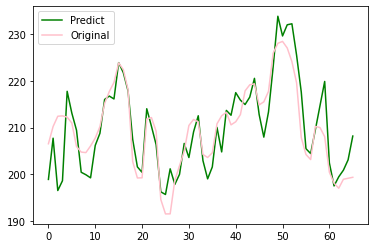

Running time: 48 seconds


In [19]:
#AT_GRU_SED
import tensorflow as tf
from tensorflow.python.keras.layers import merge
from tensorflow.python.keras.layers.merge import Multiply
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.models import *

import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Input,Dense,Reshape,Dropout, Embedding, LSTM, Bidirectional,Permute
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed
from tensorflow.python.keras.layers.recurrent import GRU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat, read_csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn.metrics as skm
import math
from math import sqrt
import time
# fix random seed for reproducibility
np.random.seed(7)

start = time.time()


#1. load dataset
dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
data = dataset.reshape(-1,6)


timestep = 6
dim = 6

#数据缩放 拆分输入X（7维）&输出Y（1维）
X = dataset[:,0:6]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in range(dim):
    Xdata = X[:,i]
    Xdata = Xdata.reshape(-1,1)
    Xdata = scaler.fit_transform(Xdata)
    Xdata = Xdata.flatten()
    X[:,i] = Xdata
X_scaler = X.reshape(324,-1)
print(X_scaler.shape)

Y = dataset[:,0]
Y_scaler= (Y-np.min(Y))/(np.max(Y)-np.min(Y))
Y_scaler = Y_scaler.reshape(-1)
print(Y_scaler.shape)


#重构数据集
##timestep为时间步长
def create_X(seq, timestep):
    dataX = []
    for i in range(len(seq)-timestep):
        a = seq[i:(i+timestep)]
        # X按照顺序取值 每次在后面增加一个数据
        dataX.append(a)
    return np.array(dataX)

def create_Y(seq, timestep):
    dataY = []
    for i in range(len(seq)-timestep):
        # Y向后移动一位取值
        dataY.append(seq[i+timestep])
    return np.array(dataY)

#-------------------------------------------#
#  建立注意力模型
#-------------------------------------------#
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
#    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
#        if print_shape_only:
#            print(layer_activations.shape)
#        else:
#            print(layer_activations)
    return activations

def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Dense(timestep, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)#(batch_size, time_steps, input_dim)
    output_attention_mul = Multiply()([inputs, a_probs])#(batch_size, time_steps, input_dim)
    return output_attention_mul


def get_gru_model():
    K.clear_session() #清除之前的模型，省得压满内存
    inputs = Input(shape=(timestep, dim,))
    attention_mul = attention_3d_block(inputs)
    gru_units1 = 60
    gru_units2 = 12
    # (batch_size, time_steps, INPUT_DIM) -> (batch_size, input_dim, lstm_units)
    gur_out1 = GRU(gru_units1,return_sequences=True)(attention_mul)
    gur_out2 = GRU(gru_units2,return_sequences=True)(gur_out1)
    # (batch_size, input_dim, lstm_units) -> (batch_size, input_dim*lstm_units)
    gur_out = Flatten()(gur_out2)
    output = Dense(1, activation='sigmoid')(gur_out)
    model = Model(inputs=inputs, outputs=output)
    return model




#预测
pres=[]
# 将数据拆分成训练和测试，7/9作为训练数据
train_size = int(len(dataset) * 0.78)
test_size = len(dataset) - train_size
trainX, testX = X_scaler[0:train_size,:], X_scaler[train_size:len(dataset),:]
trainY, testY = Y_scaler[0:train_size], Y_scaler[train_size:len(dataset)]
print("原始训练集的长度：",train_size)
print("原始测试集的长度：",test_size)
#print(trainX,trainX.shape)
#print(trainY,trainY.shape)
#print(testX,testX.shape)
#print(testY,testY.shape)

train_X=create_X(trainX,timestep)#(246,6,6)
#print(train_X,train_X.shape)
train_Y=create_Y(trainY,timestep)#(246,)
#print(train_Y,train_Y.shape)
test_X=create_X(testX,timestep)#(66,6,6)
#print(test_X,test_X.shape)
test_Y=create_Y(testY,timestep)#(66,)
#print(test_Y,test_Y.shape)

if __name__ == '__main__':

        
    model = get_gru_model()
    optimizer = Adam(0.01)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    
    model.fit(train_X, train_Y, epochs=1000, batch_size=64)

    # 开始预测
    trainPredict = model.predict(train_X)
    testPredict = model.predict(test_X)
    
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD-TVFEMD-BDX.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    testPre = testPredict*((np.max(Y)-np.min(Y)))+np.min(Y)
    testPre = testPre.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/QSX.csv', usecols=[0], engine='python')
    QSX = dataframe.values
    QSX = QSX.astype('float32')
    QSX = QSX[train_size+timestep:len(dataset)]
    QSX = QSX.reshape(-1)
    dataframe = read_csv('C:/Users/Administrator/Desktop/XI-2/data/try2ed/PD.csv', engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    Y = dataset[:,0]
    Y = Y[train_size+timestep:len(dataset)]
    #testY_ori = testY*((np.max(dataset)-np.min(dataset)))+np.min(dataset)
    #testY_ori = testY_ori.reshape((-1,1))
    testY_ori = Y.reshape((-1,1))
    for i in range(len(testY_ori)):
        testPredict[i]=QSX[i] + testPre[i]
    testPredict = testPredict.reshape(-1)
        
    error = []#Y-Y'
    error1= []#abs((Y-Y')/Y)
    error2= []#Y*Y'
    squared1 =[]#Y*Y
    squared2 =[]#Y'*Y'
    for i in range(len(testY_ori)):
        error.append(testY_ori[i] - testPredict[i])
        error1.append(abs((testY_ori[i] - testPredict[i])/testY_ori[i]))
        error2.append(testY_ori[i]*testPredict[i])
        squared1.append(testY_ori[i]*testY_ori[i])
        squared2.append(testPredict[i]*testPredict[i])
        
        
    squaredError = []#(Y-Y')^2
    absError = []#abs(Y-Y')
    for val in error:    
        squaredError.append(val * val)#target-prediction之差平方     
        absError.append(abs(val))#误差绝对值
        
    MSE=sum(squaredError) / len(squaredError)
    meannn=np.mean(testY_ori)
    NMSEerror = []
    IAerror = []
    for i in range(len(testY_ori)):
        NMSEerror.append(squaredError[i]/error2[i])
        IAerror.append((abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn))*(abs(testY_ori[i] - meannn)+abs(testPredict[i] - meannn)))
    
    U2error1 = []
    U2error2 = []
    for i in range(len(testY_ori)-1):
        U2error1.append(((testY_ori[i+1] - testPredict[i+1])/testY_ori[i])*((testY_ori[i+1] - testPredict[i+1])/testY_ori[i]))
        U2error2.append(((testY_ori[i+1] - testPredict[i])/testY_ori[i])*((testY_ori[i+1] - testPredict[i])/testY_ori[i]))
    print('\n==========================')
    MAE=sum(absError)/len(absError)
    print('MAE=',MAE)
    from math import sqrt
    RMSE=sqrt(MSE)
    print("RMSE = ", RMSE)#均方根误差RMSE
    NMSE=sum(NMSEerror)
    print("NMSE = ", NMSE)#误差平方的归一化平均值NMSE
    MAPE=sum(error1)/len(error1)
    print('MAPE=',MAPE)
    IA=1-sum(squaredError)/sum(IAerror)
    print('IA=',IA)#一致性指数
    U1index=RMSE/(sqrt(sum(squared1)/len(squared1))+sqrt(sum(squared2)/len(squared2)))
    print('U1=',U1index)
    U2index=(sqrt(sum(U2error1)/len(testY_ori)))/(sqrt(sum(U2error2)/len(testY_ori)))
    print('U2=',U2index)

    #print(testPredict)
    testPredict=testPredict.reshape(-1)
    testPredict=pd.DataFrame(testPredict)
    testPredict.to_csv('C:/Users/Administrator/Desktop/XI-2/data/pre_result/gruoutput.csv', header=False)
    import csv
    Evaluation_index = [MAE,RMSE,NMSE,MAPE,IA,U1index,U2index]
    with open("C:/Users/Administrator/Desktop/XI-2/data/pre_result/gruEvaluation.csv", "a", newline='', encoding='utf-8') as file:
        writer = csv.writer(file ,delimiter=',')
        writer.writerow(Evaluation_index)

    plt.figure(facecolor='white')
    plt.plot(testPredict,color='green', label='Predict')
    plt.plot(testY_ori,color='pink', label='Original')
    plt.legend(loc='best')
    plt.show()
    pres.append(testPredict)
    
end = time.time()
print('Running time: %d seconds'%(end - start))